In [46]:
import numpy as np
import networkx as nx
import pandas
import matplotlib.pyplot as plt
import itertools

## Load data

In [2]:
df = pandas.read_csv("data/small.csv")
df[:5]

,age,portembarked,fare,numparentschildren,passengerclass,sex,numsiblings,survived
0,1,1,1,1,1,1,1,1
1,2,2,1,1,2,2,1,2
2,1,1,1,1,1,2,1,2
3,2,1,1,1,2,2,1,2
4,2,1,1,1,1,1,1,1


In [3]:
column_names = list(df.columns)
data = np.array(df)
node_info = [(column_names[i], (np.min(data[:,i]), np.max(data[:,i]))) for i in range(data.shape[1])]
print(node_info)

[('age', (1, 3)), ('portembarked', (1, 3)), ('fare', (1, 3)), ('numparentschildren', (1, 3)), ('passengerclass', (1, 3)), ('sex', (1, 2)), ('numsiblings', (1, 3)), ('survived', (1, 2))]


## BayesNet Datastructure

In [80]:
class BayesNet:
    
    def __init__(self, adjacency_matrix, node_info):
        self.adjacency_matrix = adjacency_matrix
        self.G = nx.convert_matrix.from_numpy_array(self.adjacency_matrix, create_using=nx.DiGraph())
        self.node_info = node_info
        self.n_nodes = len(self.node_info)
        
        self.vals_per_node = [vals[1] for name, vals in node_info]
        self.node_values = [np.arange(vals[0], vals[1] + 1) for name, vals in node_info]
        self.parent_sets = [list(self.G.predecessors(i)) for i in self.G.nodes]
        
        n_parental_instances = [np.prod([self.vals_per_node[p] for p in parents]) for parents in self.parent_sets]
        m_matrices = [np.zeros((int(npis), int(vals))) for npis, vals in zip(n_parental_instances, self.vals_per_node)]
        
        self.ms = m_matrices
    
    def count_ms(self, data):
        for i in range(self.n_nodes):
            parents = self.parent_sets[i]
            n_parents = len(parents)
            if n_parents > 0:
                parental_instantiations = itertools.product(*[self.node_values[p] for p in parents])
                for j, pi in enumerate(parental_instantiations):
                    mask = data[:,parents[0]] == pi[0]
                    for k in range(1,n_parents):
                        mask = np.logical_and(mask, data[:,k] == pi[k])
                    pi_data = data[mask,i]
                    vals, counts = np.unique(pi_data, return_counts=True)
                    self.update_counts(i, j, vals, counts)
            else:
                vals, counts = np.unique(data[:,i], return_counts=True)
                self.update_counts(i, 0, vals, counts)
    
    def update_counts(self, node, pi, vals, counts):
        for v, c in zip(vals, counts):
            self.ms[node][pi, v - 1] += c
    
    @property
    def is_dag(self):
        return nx.is_directed_acyclic_graph(self.G)
    
    def draw(self):
        nx.draw(self.G, labels={i:info[0] for i, info in enumerate(self.node_info)})
        

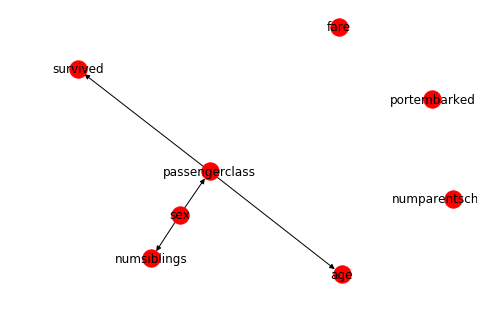

In [81]:
no_dag = True
while no_dag:    
    A = np.random.binomial(1, 0.1, size=[len(node_info)] * 2)
    np.fill_diagonal(A, 0)
    g = BayesNet(A, node_info)
    no_dag = not g.is_dag
g.draw()

In [82]:
g.count_ms(data)

In [84]:
g.ms

[array([[208., 276.,   7.],
        [ 44., 140.,  30.],
        [ 67., 105.,  12.]]),
 array([[644., 168.,  77.]]),
 array([[869.,  17.,   3.]]),
 array([[794.,  85.,  10.]]),
 array([[347., 122., 108.],
        [144.,  92.,  76.]]),
 array([[577., 312.]]),
 array([[552.,  21.,   4.],
        [291.,  18.,   3.]]),
 array([[372., 119.],
        [ 80., 134.],
        [ 97.,  87.]])]

In [ ]:
G = nx.DiGraph()
G.add_edge(1,2)
G.add_edge(3,4)
G.add_edge(4,1)
nx.draw(G, labels={i+1:str(i + 1) for i in range(4)})

In [46]:
A = nx.to_numpy_array(G)

In [68]:
parents = [G.predecessors(node) for node in G.nodes]


[4]

In [42]:
X = np.zeros((3,3))
X[1,0] = 1
X[1,1] = 1
X[1,2] = 1
X[0,0] = 1
X[0,1] = 1

In [44]:
mask = np.logical_and(X[:,0] == 1, X[:,1] == 1)
X[mask,-1]

array([0., 1.])

In [38]:
A[mask]

IndexError: boolean index did not match indexed array along dimension 0; dimension is 8 but corresponding boolean dimension is 3

In [49]:
for j in itertools.product((), ()):
    print("hi")

In [51]:
a = np.array([1,1,2,3,4,6,7,3,3])
np.unique(a, return_counts=True)

(array([1, 2, 3, 4, 6, 7]), array([2, 1, 3, 1, 1, 1], dtype=int64))